## IMAGE INPAINTING USING WASSERSTEIN GENERATIVE ADVERSARIAL IMPUTATION NETWORK

**Authors: Daniel Vašata, Tomáš Halama and Magda Friedjungová**

**Presenter: Abhijith Srinivas Bidaralli**

**Supervisor: Dr. Pascal Tobias Peter**

## Abstract
Image inpainting, also known as image completion, aims to restore lost pixels in an image with missing regions. We impute the pixel information in missing locations based on the non-missing parts of the image, thereby reconstructing the lost parts.

This paper aims to introduce an image inpainting model based on Wasserstein Generative Adversarial Imputation Network. The generator network of the
model uses convolutional layer blocks of different dilation rates, together with skip connections that help the model to propagate high resolution features to output.The discriminator network, called the critic, calculates the Wasserstein Distance, which considers the distance between the real and fake image distributions. The model was simultaneously trained on a hybrid input of three missing scenarios given by random noise from uniform distribution, randomnly located multiple squares, and one large square placed in center of image.

The authors claim that the above model architecture and implementation strategy for training gives us a universal imputation model that can achieve sufficient quality imputation for various scenarios of missingness.

Performance was evaluated using peak signal-to-noise ratio and structural similarity index on two real-world benchmark datasets, CelebA faces and Paris StreetView.

## 1. Introduction

Inpainting, one of the most important computer vision tasks, aims to restore missing pixels in a damaged image. We estimate and impute these missing pixels by deriving information from the non-missing parts of the image.
Since the missingness can appear in many shapes and sizes, the goal is to have a universe imputation model that can handle these different scenarios.

Conventional approaches of inpainting was more mathematical, where it was treated as a smooth function extension problem. This worked very well when the image corruption was minor as it heavily relies on local features such as color and texture from adjacent pixels. One of the approaches is the biharmonic functions which the authors have also chosen for the qualitative and quantitative comparison with WGAIN. It uses differential equation to solve for pixel values inside the hole, where filled-in pixel values change smoothly from the boundary toward the hole center.

However, the above approaches work well only for minor damage and not significant image corruption. This is mainly due to the fact that it relies more on local features and fails to take into account global semantics of image, which is where Neural Networks makes up for this inefficacy.
Currently, the most successful methods are the deep generative models with the convolutional layers.

Amongst the deep generative models, the authors aim to introduce the Wasserstein Generative Adversarial Network for imputation purposes. What makes this different from the vanilla GAN is that it finds the Wasserstein Distance between real and fake image distribution, which is used in the calculation of loss.

The authors make use of convolutional layer blocks with different dilation rates, that increase the receptive field but whilst maintaining fewer parameters. Skip connections are used, which helps reproduce fine details of the output. The authors then train this model on three different missing scenarios (random noise, multiple squares and center square) by passing it as a hybrid input, that trains for all of them at once. Model obtained at the end is claimed to be a universal imputation model.

In this write-up, I aim to verify this claim of the authors through carefully crafted experiments. We will first be checking if the model is indeed a universal imputation model and if not, what changes can be made to improve the inpainting results.


### 1.1 Related Work

The Authors took inspiration from two papers. They used the implementation strategy of the original GAN paper [[FVBJ20]](#Bibliography)  and enhanced this by replacing the fully connected layers of original paper with convolutional layers. They also trained on three missing scarios instead of one.
The architecture was inspired by  paper [[JKDW+20]](#Bibliography) . It involves the usage of skip connections and dilated convolutions.

The contribution of this paper was that it performs better than the non-DL methods, it performs comparably well with other SOTA models. And the authors contend that it’s a Universal Imputation Model. Their claim is closely tied to the model being trained on the 3 missing scenarios.

### 1.2 Organisation of the Write-Up

We first will discuss the implementation strategy for training and architecture of the WGAIN network in [Section 2](#2.-Wasserstein-Generative-Adversarial-Imputation-Network). In [Section 3](#3.-Practical-Experiments), we will check and verify if it indeed is a universal imputation model. If not, we will see if any modifications can be made to improve the inpainting results. Finally, we conclude the write-up with a [short summary](#Conclusions-and-Future-work).

Before we move on to the next sections, run the following code cells below to ensure all necessary packages have been downloaded!

In [ ]:
!apt-get install ffmpeg libsm6 libxext6
!apt-get install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip install --no-cache-dir --upgrade pip
!pip install --no-cache-dir -r requirements.txt

## 2. Wasserstein Generative Adversarial Imputation Network


Here we discuss the implementation strategy and model architecture used by the authors more closely. We will also have a closer look at the missing scenarios the authors trained the model on.


### 2.1 Theory and Implementation

Consider a real image distribution given by $\chi = \mathbb{R}^{m,n,3}$. This is the space of all possible images with size $m \times n$ and three color channels <b> RGB </b>. 

#### <u>Steps of Implementation for Training </u>:
Given below are the steps of implementation for training the authors used:

<b>Step 1 </b>:Take an image $X$ from this real image distribution. This is just a random element with probability $P(X)$.

<b>Step 2</b>: In this step, we will construct the mask matrice $M$ which is just a boolean matrix of 1s and 0s. This corresponds to the distribution of missingness in the data. 

\begin{equation*}
M = \left\{
        \begin{array}{ll}
            1, & \quad \text{if $ij$th pixel of $X$ is valid} \\
            0, & \quad \text{if $ij$th pixel of $X$ is missing}
        \end{array}
    \right.
\end{equation*}

After we construct the mask matrix, we will be applying it to the image $X$ with a simple element-wise multiplication performed along all three color channels.

\begin{equation*}
\tilde{X} = X \odot M
\end{equation*}

<b>Step 3 </b>: In this step we will replace the missing pixels with noise sampled from a normal distribution $\mathcal{N}(\mu\,\sigma^{2})$.
We first construct a tensor $Z \in \mathbb{R}^{m,n,3}$ with all its values sampled from the above distribution.
\begin{equation*}
\tilde{Z} = Z \odot (1-M)
\end{equation*}
We then add this to the missing pixels by doing so:

\begin{equation*}
\tilde{X}_z = \tilde{Z} + \tilde{X} 
\end{equation*}
\begin{equation*}
\tilde{X}_z = Z \odot (1-M) + X \odot M
\end{equation*}

<b>Step 4 </b>: Now we pass this masked image, which has had its missing pixels replaced with noise from a normal distribution, along with the mask matrix to the generator. The generator will reconstruct the whole image. We then only take the reconstructed imputed regions from this and add it to the masked image. This is given below as follows:

\begin{equation*}
\hat{X}_z = g(\tilde{X}_z , M) \odot (1-M) + X \odot M
\end{equation*}

The above generates the imputed objects which are to be added to the missing region of masked image. Simple analogy to explain this better is to think about it as adding missing pieces to a puzzle.

<b>Step 5 </b>: Once we have the imputed image, we will pass this on to the critic to calculate the Wasserstein Distance between the real image and imputed image.

\begin{equation*}
\ E_{X \sim P(X), M \sim P(M)}(f(X,M) - E_{Z \sim P(Z)}f(\hat{X}_z,M))
\end{equation*}
</br>

#### <u>Objective Functions for Training </u>:
\begin{equation*}
\ J(f) = E_{X \sim P(X), M \sim P(M)}λ_f(f(X,M) - E_{Z \sim P(Z)}f(\hat{X}_z,M))
\end{equation*}
Discriminator objective function is based on the Wasserstein distance. It wants to maximize this for distinguishing better. We have hyper parameter $λ_f$ to control influence of gradient.

\begin{equation*}
\ J(g) = E_{X \sim P(X), Z \sim P(Z), M \sim P(M)}(-λ_g(\hat{X}_z,M) + λ_{MAE}\mathcal{L}_{MAE}f(\hat{X}_z,X))
\end{equation*}
The generator objective function is coupled with the critic function and also has the reconstructions loss function, given by absolute error loss. The corresponding lambdas are to control the influence of the respective gradients. Generator wants to minimize distance between the real and fake image distribution.

The generator and critic (discriminator) are playing an iterative minimax game, where the critic wants to recognize the imputed regions better while the generator wants to generate these regions so well that the critic will not be able to distinguish between real and fake.

### 2.2 Model Architecture

#### <b><u>Generator Architecture: </b></u>
Generator has an encoder-decoder topology with skip connections.
We have 3 parallel convolutional and deconvolutional layer blocks as shown in the figure below. 

The skip connections allow the model to propagate high resolution features from layers of the encoder into layers of the decoder, transferring finer details better.
Another thing to be noted is that the first skip connection is just the concatenation of networks input (X,Z,M)

The convolutional layers also make use of something called dilated convolution. In simpler terms, it is the same as convolution, but it involves pixel skipping, so as to cover a larger area of the input. This is a computationally cheap way of increasing the receptive field.  It also improves the ability of the model to focus on both the local and global structure of the image.

We have ELU activations between the blocks for the non-linearity.
Up-sampling and down-sampling operations are being done by a factor of 2X2. The final block of the decoder is not up-sampled but only concatenated with the first skip connection and fed into the one other deconvolutional layer with 8 channels, kernel size of 3 × 3.
At the end we pass it into a deconvolutional layer of 3X3 and 3 channels with hard sigmoid function, to retrieve the final reconstructed image.


<img src="images/generator_arch.png"/>

**Figure 1**: *The architecture of the generator*

#### <b><u>Critic Architecture: </b></u>

It has a simple funnel topology. Stack of convolutional layers of different depths. All have Leaky relu activation. The final output is flattened and fed into a single neuron with linear activation. This produces a real number representing the confidence of prediction.

Weight clipping is being done at the layers to ensure the Lipschitz constraint. A very important criteria to be met for training of the WGAIN. This is being done after every weight update.


### 2.3  Scenarios of missingness

The authors trained the model on the following scenarios of missingness:

1.   **Noise**: Noise is sampled randomly from uniform distribution lying in interval of $[0.5, 0.95]$ and is applied to the image . During the test phase, we only consider 3 cases which are 0.5 ,0.75 and 0.95
2.   **Center Square**: During training a large square is cropped from the center of image, with its side randomly chosen between this interval of $[l/2.5, l/1.6]$. This was done to represent task of imputing a large continuous region. During the test phase the side of square was just half length of image. Here, the missing portion is said to be 25%.
3.   **Multiple Squares**: This is a compromise between the previous two types of masks. There are multiple smaller squares of size 31X31 pixels, which were uniformly and independently distributed across the image. Lower left corners distributed in 2D interval of $[-2l, 3l]^2$ and sides distributed uniformly in interval $[l/5, l/3]$. Due to overlapping of multiple squares, the missing portion is approximately 25%.

All of the above correspond to the construction of the damage mask matrices which was discussed in the previous sub-section. The boolean mask matrices will be constructed in such a way that when applied to an image, we will obtain either the noise masking, center square masking or multiple square masking.
For a given batch of images, each image will be assigned any mask matrice, to be applied on it, based on probability measures. Hence, during the training phase, the model learns all these scenarios at once.

Obviously, trying to visualize all this is a tad bit difficult. Not to worry! The code cells below illustrates how the dataset preparation was done. 
There are already 100 images each in both the train128 and test128 folders (found inside ./datasets/celeba).

In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import data
from tensorflow import keras
import matplotlib.pyplot as plt
from random import randint, seed
from WGAIN_model import *
from numpy.random import default_rng

In [2]:
def prepare_training_dataset(ds, batch_size, side):
    def decode_img(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    def introduce_missingness(X):
        # noise mask
        # per row ratios how much should be thrown (each row a different number, max is max_ratio_to_throw)
        ratio_to_throw = tf.random.uniform((X.shape[0],), minval = 0.50, maxval = 0.95)
        ratio_to_throw = tf.reshape(ratio_to_throw, ratio_to_throw.shape + [1, 1])
        ratio_to_throw = tf.repeat(ratio_to_throw, [side], axis = 1)
        ratio_to_throw = tf.repeat(ratio_to_throw, [side], axis = 2)
        ratio_to_throw = tf.reshape(ratio_to_throw, [X.shape[0], side, side, 1])
        # binary mask of which features are left (0 - missing, 1 - OK)
        mask_noise = tf.dtypes.cast(tf.math.greater(tf.random.uniform([X.shape[0], side, side, 1]), ratio_to_throw), tf.float32)
        # centered square
        sides = np.random.randint(low = side//2.5, high = side//1.6, size=batch_size)
        corner_l = int(side / 2.0) -  (sides/2.0).astype(int)
        corner_u = int(side / 2.0) +  (sides/2.0).astype(int)
        center_mask = np.ones((batch_size, side, side, 1)).astype('float32')
        for i in range(batch_size):
            center_mask[i,corner_l[i]:corner_u[i],corner_l[i]:corner_u[i],:] = 0
        center_mask = tf.constant(center_mask, dtype=tf.float32)
        # several squares
        N = 30
        ll_x = np.random.randint(low = -side*2, high = side*3, size=(X.shape[0], N))
        ll_y = np.random.randint(low = -side*2, high = side*3, size=(X.shape[0], N))
        sizes = np.random.randint(low = side//5, high = side//3, size=(X.shape[0], N))
        ur_x = ll_x + sizes
        ur_y = ll_y + sizes
        mask_squares = np.ones((X.shape[0], side, side, 1)).astype('float32')
        for j in range(X.shape[0]):
            for i in range(N):
                mask_squares[j,ll_x[j,i]:ur_x[j,i],ll_y[j,i]:ur_y[j,i],:] = 0
        mask_squares = tf.constant(mask_squares, dtype=tf.float32)
        # agregate mask randomly for each image
        ratio_to_agg = tf.random.uniform((X.shape[0],), minval = 0, maxval = 0.9)
        ratio_to_agg = tf.reshape(ratio_to_agg, ratio_to_agg.shape + [1, 1])
        ratio_to_agg = tf.repeat(ratio_to_agg, [side], axis = 1)
        ratio_to_agg = tf.repeat(ratio_to_agg, [side], axis = 2)
        ratio_to_agg = tf.reshape(ratio_to_agg, [X.shape[0], side, side, 1])
        choice_1 = tf.dtypes.cast(tf.math.less(ratio_to_agg, 0.3), tf.float32)
        choice_2 = tf.dtypes.cast(tf.math.greater(ratio_to_agg, 0.6), tf.float32)
        choice_3 = 1 - choice_1 - choice_2
        mask = tf.math.multiply(choice_1, mask_noise) + tf.math.multiply(choice_2, mask_squares) + tf.math.multiply(choice_3, center_mask)
        # Do the mask to have 3 channels
        mask3 = tf.repeat(mask, [3], axis = 3)
        # prepare randomness
        randZ = tf.random.normal([X.shape[0], side, side, 3], mean = 0.0, stddev = 0.1)
        randZ = tf.math.multiply(1 - mask3, randZ)
        # apply the mask - leave original and substitute randoms for missings
        newX = tf.math.multiply(mask3, X)
        # return a training pair
        return (X, newX, mask, randZ)
    # do the preparation
    ds = ds.map(decode_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(buffer_size = 1024)
    ds = ds.batch(batch_size,drop_remainder = True)
    ds = ds.map(lambda x:tf.numpy_function(introduce_missingness, [x], (tf.float32,tf.float32,tf.float32,tf.float32)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds

In [3]:
print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))


##########################################################################
batch_size = 32
side = 128

path = "./datasets/celeba/%s128"
celeba_train = data.Dataset.list_files(path%'train' + str('/*.jpg'))
celeba_train_d = prepare_training_dataset(celeba_train, batch_size, side)

2.8.2
Num GPUs Available:  0


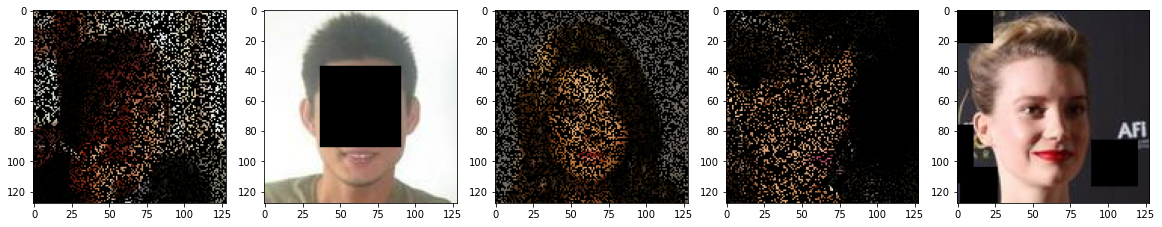

In [4]:
it = iter(celeba_train_d)
origX, newX, mask, randZ = next(it)
plt.figure(figsize=(20,8))
for i in range(min(5, batch_size)):
    plt.subplot(2,5,i+1)
    plt.imshow(newX[i,:,:,:])
plt.show()

<div class="alert alert-block alert-info">
Above code cell can be run again and again to see results over new batches of images!
You will see new results each time you run the cell.
</div>

## 3. Practical Experiments

In this section, we will verify the authors claim on their model being a universal imputation model. We will then explore modifications that can improve the inpainting results.

### 3.1 Experiment 1

Throughout the entire training, the authors used three missing scenarios, which were passed as a hybrid input. One interesting observation to be made is that the two scenarios made use of definite geometric shapes. Either a large center square or multiple squares of slightly differing sizes were removed. Both of these missing scenarios accounted for 25% missingness.

Question to be asked now is, what would happen if we were to apply a mask that wasn't a definite geometric shape? Something irregular and spread out?

The following experiment aims to explore this. We will first create a custom irregular mask and apply it to a batch of images. This will be passed on to the model which was trained by the authors. The inpainting results obtained will be inspected.

#### Creating a custom mask

For this, a cat image was chosen to create a custom binary mask. Size was adjusted in such a way as to ensure a 25% missingness. This was done to ensure consistency of results and to mainly compare the difference in inpainting results between masks that used definite geometric shape and a mask that uses an irregular binary mask.

Run the following code cells!

In [5]:
import os
import PIL
from os import listdir
from PIL import Image
import random
import numpy.ma as ma
from skimage.metrics import structural_similarity as SSIM

In [6]:
img = tf.io.read_file('./images/cat.png')
img = tf.image.decode_png(img, channels=1)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, (117, 117))
img = ma.masked_greater(img, 0)
custom_img=img.mask.astype(int)
custom_img = 1 - custom_img

In [7]:
def prepare_customMask_eval_dataset(ds, batch_size, side):
    def decode_img(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    def introduce_missingness(X):
        # centered square
        sides = np.ones(shape=(X.shape[0],))*int(side/2.0)
        corner_l = int(side / 2.0) -  (sides/2.0).astype(int)
        corner_u = int(side / 2.0) +  (sides/2.0).astype(int)
        center_mask = np.ones((X.shape[0], side, side, 1)).astype('float32')
        for i in range(X.shape[0]):          
            center_mask[i,corner_l[i]:corner_u[i],corner_l[i]:corner_u[i],:] = 0
        # binary mask of which features are left (0 - missing, 1 - OK)
        mask_ss = tf.constant(center_mask, dtype=tf.float32)
        # Do the mask to have 3 channels
        mask3_ss = tf.repeat(mask_ss, [3], axis = 3)
        # prepare randomness
        randZ_ss = tf.random.normal([X.shape[0], side, side, 3], mean = 0.0, stddev = 0.1)
        randZ_ss = tf.math.multiply(1 - mask3_ss, randZ_ss)
        # apply the mask - leave original and substitute randoms for missings
        newX_ss = tf.math.multiply(mask3_ss, X)
        # Custom Mask
        corner_l = np.random.randint(low = 5, high = 10, size=batch_size)
        corner_u = int(side / 2.0)  +  corner_l + 53
        custom_mask = np.ones((batch_size, side, side, 1)).astype('float32')
        for i in range(batch_size):
            custom_mask[i,corner_l[i]:corner_u[i],corner_l[i]:corner_u[i],:] = custom_img
        mask_cs = tf.constant(custom_mask, dtype=tf.float32)
        mask3_cs = tf.repeat(mask_cs, [3], axis = 3)
        # prepare randomness
        randZ_cs = tf.random.normal([X.shape[0], side, side, 3], mean = 0.0, stddev = 0.1)
        randZ_cs = tf.math.multiply(1 - mask3_cs, randZ_cs)
        # apply the mask - leave original and substitute randoms for missings
        newX_cs = tf.math.multiply(mask3_cs, X)
        # return a training pair
        return (X, newX_ss, mask_ss, randZ_ss,newX_cs, mask_cs, randZ_cs)
    # do the preparation
    ds = ds.map(decode_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(buffer_size = 1024)
    ds = ds.batch(batch_size,drop_remainder = True)
    #ds = ds.map(introduce_missingness, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.map(lambda x:tf.numpy_function(introduce_missingness, [x], (tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
batch_size = 32
side = 128

path = "./datasets/celeba/%s128"
celeba_test = data.Dataset.list_files(path%'test' + str('/*.jpg'))
celeba_test_customMask = prepare_customMask_eval_dataset(celeba_test, batch_size, side)

# create the model
generator = build_generator(side)
# generator.summary()
critic = build_critic(side)
# critic.summary()

# Load weights
model_path = "saved_models_celeba_old/"

generator.load_weights(model_path + "gultimate_final")
critic.load_weights(model_path + "cultimate_final")

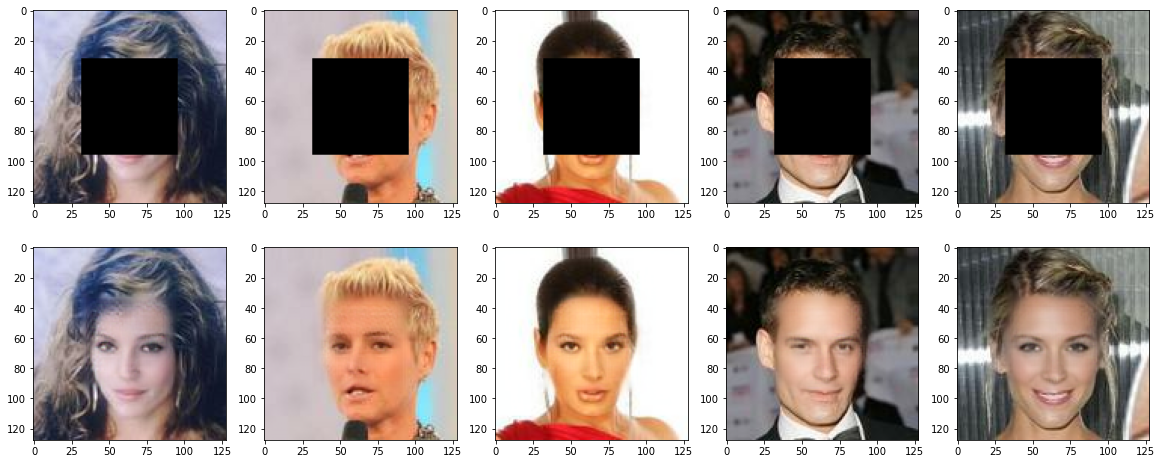

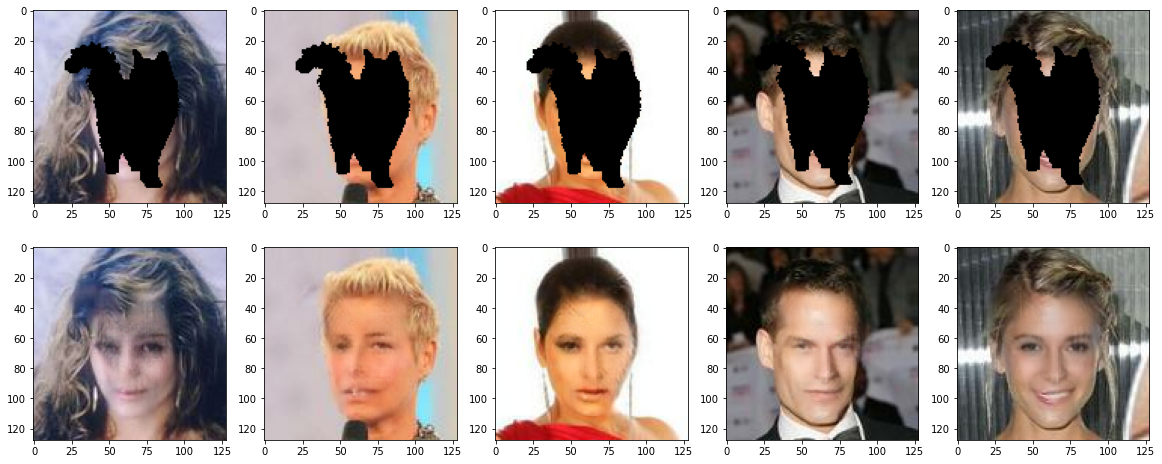

In [9]:
it = iter(celeba_test_customMask)
origX, newX_ss, mask_ss, randZ_ss,newX_cs, mask_cs, randZ_cs = next(it)
g_out = generator([newX_ss, mask_ss, randZ_ss])
plt.figure(figsize=(20,8))
for i in range(min(5, batch_size)):
    plt.subplot(2,5,i+1)
    plt.imshow(newX_ss[i,:,:,:])
    plt.subplot(2,5,i+6)
    plt.imshow(g_out[i,:,:,:])
plt.show()
g_out = generator([newX_cs, mask_cs, randZ_cs])
plt.figure(figsize=(20,8))
for i in range(min(5, batch_size)):
    plt.subplot(2,5,i+1)
    plt.imshow(newX_cs[i,:,:,:])
    plt.subplot(2,5,i+6)
    plt.imshow(g_out[i,:,:,:])
plt.show()


<div class="alert alert-block alert-info">
Above code cell can be run again and again to see results over new batches of images!
You will see new results each time you run the cell.
</div>

From the above results, we observe that the inpainting results for center square is of sufficient quality. However, the cat mask produces artifacts in the final output.
The interesting point to be noted here is that though the missingness percentage is 25% for both, the inpainting results differ qualitatively.

This contradicts the authors claim of their model being a universal imputation model.

<div class="alert alert-block alert-info">
Note: You can create your own irregular binary mask as well! Just import your own image and ensure the missingness is 25%.
</div>

### 3.2 Experiment 2

From the previous experiment, we observed that using an irregular shaped mask creates artifacts in the image. This contradicts the authors assertion of their model being able to handle various scenarios of missingness.

Let's take another look at the missing scenarios the authors trained the model on. The scenario of multiple missing squares is what should pique our interest! This was selected as a compromise between the center square scenario and noise scenario. It is said to bridge the gap between the two.

On closer inspection, we notice that the multiple square scenario is not so efficient. A notable number of times, the squares were initialized very close to the border or beyond. As a result, nothing of significance will be learnt, as most of the important image content is away from the border.

During the training phase, 30 squares of 31X31 pixels were used to induce the missingness. A careful study will reveal that this is not the case. As overlapping is allowed, we will see an average of 5-6 squares on the image. Also, as mentioned before, a good amount of these squares were created close to boundary or beyond.

So the question we can ask ourselves is, can we find a better approach to deal with this inefficacy? Perhaps use an alternative?

A good mask would be one which depicts continuous missing regions better. On training with such a mask, it should be able to manage sufficiently well both regular and irregular regions of missingness.

All of these above questions and thoughts are what served as an inspiration for the following carefully crafted experiment!

#### <b><u>Irregular Shape Mask for Training:</b></u>




In this approach, we will experiment with the CelebA dataset. Let us replace the multiple squares with something else.  

Four circles and four ellipses were chosen for construction of the mask matrice . The radius of circle varies between 10 and 18. The minor and major axis of ellipse varies between (6,10) and (27,31).
Another constraint was added, where we ensure that for the 128X128 image, all the shapes appear within 100X100 of that. Adding this would make sure all the shapes were around or in center of image, ensuring the model would learn the reconstruction of face better.

Run the following code cells below!

In [10]:
def prepare_irregularShapes_eval_dataset(ds, batch_size, side):
    def decode_img(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    def introduce_missingness(X):
        # irregular mask
        img = np.zeros((batch_size,side, side, 1)).astype('float32')
        # Set size scale
        width = side
        height = side
        size = int((width + height) * 0.015)
        if width < 64 or height < 64:
            raise Exception("Width and Height of mask must be at least 64!")
        for j in range(X.shape[0]):
            for i in range(4):
              radius = randint(10,18)
              x1, y1 = randint(28, width-28), randint(28, height-28)
              cv2.circle(img[j],(x1,y1),radius,(1,1,1), -1)
              s1, s2 = randint(6,10) , randint(27,31)
              x1, y1 = randint(28, width-28), randint(28, height-28)
              a1, a2, a3 = randint(3, 180), randint(3, 180), randint(3, 180)
              cv2.ellipse(img[j], (x1,y1), (s1,s2), randint(0, 180), 0 , 360,(1,1,1), -1)
        mask_shapes = 1-img
        mask_shapes = tf.constant(mask_shapes, dtype=tf.float32)
        # Do the mask to have 3 channels
        mask3 = tf.repeat(mask_shapes, [3], axis = 3)
        # prepare randomness
        randZ = tf.random.normal([X.shape[0], side, side, 3], mean = 0.0, stddev = 0.1)
        randZ = tf.math.multiply(1 - mask3, randZ)
        # apply the mask - leave original and substitute randoms for missings
        newX = tf.math.multiply(mask3, X)
        # return a training pair
        return (X, newX, mask_shapes, randZ)
    # do the preparation
    ds = ds.map(decode_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(buffer_size = 1024)
    ds = ds.batch(batch_size,drop_remainder = True)
    ds = ds.map(lambda x:tf.numpy_function(introduce_missingness, [x], (tf.float32,tf.float32,tf.float32,tf.float32)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
batch_size = 32
side = 128

path = "./datasets/celeba/%s128"
celeba_test = data.Dataset.list_files(path%'test' + str('/*.jpg'))
celeba_test_d = prepare_irregularShapes_eval_dataset(celeba_test, batch_size, side)

Average missingness % per batch:  24.648666381835938


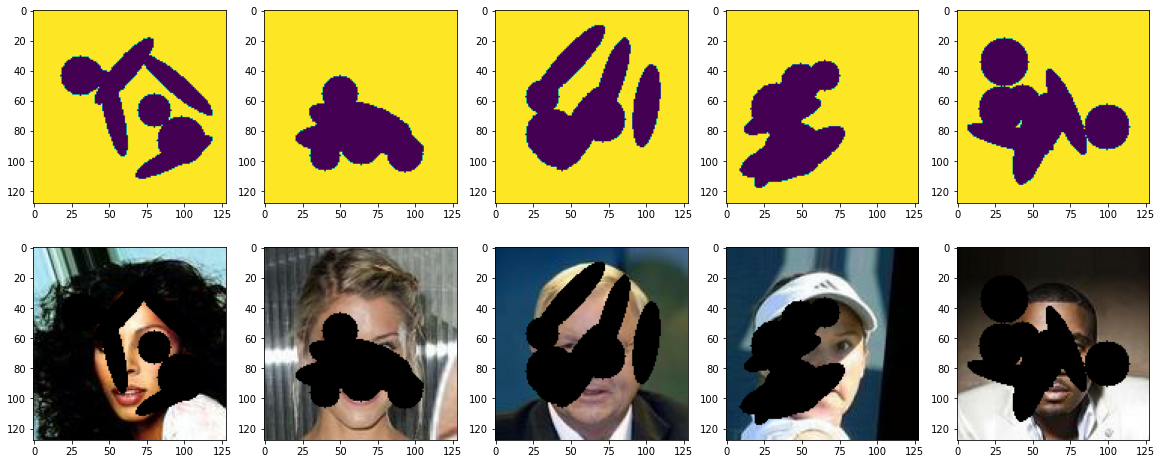

In [12]:
it = iter(celeba_test_d)
origX, newX, mask, randZ = next(it)
avg = 0
for m in mask:
  avg += (side*side - np.count_nonzero(m))
avg = avg/len(mask)
avg_missingness = avg/(side*side)
print("Average missingness % per batch: ",avg_missingness*100)
mask3 = tf.repeat(mask, [3], axis = 3)

plt.figure(figsize=(20,8))
for i in range(min(5, batch_size)):
    plt.subplot(2,5,i+1)
    plt.imshow(mask[i,:,:,:])
    plt.subplot(2,5,i+6)
    plt.imshow(newX[i,:,:,:])
plt.show()

We can clearly see that the overlapping of these circles and ellipses of different shapes and orientations creates bigger irregular shapes and blobs. All of this is achieved with the same missingness percentage of 25%!

<div class="alert alert-block alert-info">
Above code cell can be run again and again to see results over new batches of images!
You will see new results each time you run the cell.
</div>

We can incorporate this into the dataset preparation function, as done in the included WGAIN_model_modified.py file. The multiple squares mask is merely being replaced by our irregular shape mask.

Once this is done, we can begin training the model again from scratch. However, this is totally optional and completely your decision! The training has already been done over the whole CelebA dataset upto 110 epochs with a batch size of 16 images.
If you wish to avoid this, you can skip this training section.

#### Training the Model

First we need to load and prepare the train and test data. In this case we use the CelebA database. In order to execute smoothly, please __[download it](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)__ and run below cell to prepare the data into train and test.

In [13]:
import os
import PIL
from os import listdir
from PIL import Image
import random

In [ ]:
path = "img_align_celeba"
path_train = "train128"
path_test = "test128"
i = 0
random.seed(2020)
for file in listdir(path):
    im = Image.open(path+'/'+file)
    im = im.crop((0,20,178,198)).resize((128,128), Image.ANTIALIAS)
    im.save((path_train if random.random() >= 0.3 else path_test)+"/"+file[:-4]+".jpg", "JPEG")

Once this is done, move the train128 and test128 folders into "./datasets/celeba".
The folders must have 142,053 and 60,546 files respectively.

Now we can start the training. Just execute the code cell below!

In [17]:
#!/usr/bin/python3 -u
# coding: utf-8
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import data
from tensorflow import keras
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
keras.backend.clear_session()

import sys
#sys.exit(0)
#sys.path.insert(1, './inpainting')
from WGAIN_model_modified import *

print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))


##########################################################################
batch_size = 32
side = 128

path = "./datasets/celeba/%s128"
celeba_train = data.Dataset.list_files(path%'train' + str('/*.jpg'))
celeba_train_d = prepare_training_dataset(celeba_train, batch_size, side)

# create the model
generator = build_generator(side)
critic = build_critic(side)
# print summaries
generator.summary()
critic.summary()
# prepare optimizers
generator_optimizer = tf.keras.optimizers.Adam(0.00005)
critic_optimizer = tf.keras.optimizers.Adam(0.00005)


@tf.function
def train_step(origX, newX, mask, randZ):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as critic_tape:
        g_out = generator([newX, mask, randZ])
        opinion_generated = critic([g_out, mask])
        opinion_real = critic([origX, mask])
        critic_w_l = wass_c_loss(opinion_generated, opinion_real)
        gen_w_l = 0.005*wass_g_loss(opinion_generated)
        gen_mse_l = g_loss(g_out, origX)
        gen_loss = gen_mse_l + gen_w_l

    g_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    c_gradients = critic_tape.gradient(critic_w_l, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(c_gradients,critic.trainable_variables))
    generator_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    return gen_mse_l, gen_w_l, critic_w_l

##### Main training
g_history = []
m_history = []
d_history = []

# Path to save
model_path = "saved_models_celeba/"
#generator.load_weights(model_path + "gultimate_ckpt100")
#critic.load_weights(model_path + "cultimate_ckpt100")

# main loop
for epoch in range(1,201):
    print("Epoch: %d" % epoch)
    # Store selected losses
    losses_g = []
    losses_m = []
    losses_d = []
    for i, (origX, newX, mask, randZ) in enumerate(celeba_train_d):
        print(".", end='', flush=True)
        mse_l, genw_l, critic_l = train_step(origX, newX, mask, randZ)
        losses_m.append(mse_l)
        losses_g.append(genw_l)
        losses_d.append(critic_l)
    print()
    g_history.append(np.mean(losses_g))
    m_history.append(np.mean(losses_m))
    d_history.append(np.mean(losses_d))
    print("gen W loss:", np.mean(losses_g))
    print("gen mae loss:", np.mean(losses_m))
    print("critic loss:", np.mean(losses_d))
    generator.save_weights("saved_models_celeba/gultimate_latest")
    critic.save_weights("saved_models_celeba/cultimate_latest")
    if epoch%1==0:
        generator.save_weights("saved_models_celeba/gultimate_ckpt%d" % epoch)
        critic.save_weights("saved_models_celeba/cultimate_ckpt%d" % epoch)


# Final save of weights
generator.save_weights("saved_models_celeba/gultimate_final")
critic.save_weights("saved_models_celeba/cultimate_final")


2.8.2
Num GPUs Available:  0
Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 mask (InputLayer)              [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 random (InputLayer)            [(None, 128, 128, 3  0           []                               
                                )]                           

 up_sampling2d_1 (UpSampling2D)  (None, 64, 64, 256)  0          ['concatenate_6[0][0]']          
                                                                                                  
 concatenate_7 (Concatenate)    (None, 64, 64, 384)  0           ['up_sampling2d_1[0][0]',        
                                                                  'concatenate_2[0][0]']          
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 64, 64, 32)  307232      ['concatenate_7[0][0]']          
 spose)                                                                                           
                                                                                                  
 conv2d_transpose_4 (Conv2DTran  (None, 64, 64, 32)  307232      ['concatenate_7[0][0]']          
 spose)                                                                                           
          

Total params: 5,947,329
Trainable params: 5,947,329
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch: 1
...
gen W loss: -5.2654956e-05
gen mae loss: 0.26645067
critic loss: -0.0007919701


#### Testing the Model

Now let us test whether our approach really works or not. Run the code cells below!

In [14]:
def prepare_customMask_eval_dataset(ds, batch_size, side):
    def decode_img(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    def introduce_missingness(X):
        # centered square
        sides = np.ones(shape=(X.shape[0],))*int(side/2.0)
        corner_l = int(side / 2.0) -  (sides/2.0).astype(int)
        corner_u = int(side / 2.0) +  (sides/2.0).astype(int)
        center_mask = np.ones((X.shape[0], side, side, 1)).astype('float32')
        for i in range(X.shape[0]):          
            center_mask[i,corner_l[i]:corner_u[i],corner_l[i]:corner_u[i],:] = 0
        # binary mask of which features are left (0 - missing, 1 - OK)
        mask_ss = tf.constant(center_mask, dtype=tf.float32)
        # Do the mask to have 3 channels
        mask3_ss = tf.repeat(mask_ss, [3], axis = 3)
        # prepare randomness
        randZ_ss = tf.random.normal([X.shape[0], side, side, 3], mean = 0.0, stddev = 0.1)
        randZ_ss = tf.math.multiply(1 - mask3_ss, randZ_ss)
        # apply the mask - leave original and substitute randoms for missings
        newX_ss = tf.math.multiply(mask3_ss, X)
        # Custom Mask
        corner_l = np.random.randint(low = 5, high = 10, size=batch_size)
        corner_u = int(side / 2.0)  +  corner_l + 53
        custom_mask = np.ones((batch_size, side, side, 1)).astype('float32')
        for i in range(batch_size):
            custom_mask[i,corner_l[i]:corner_u[i],corner_l[i]:corner_u[i],:] = custom_img
        mask_cs = tf.constant(custom_mask, dtype=tf.float32)
        mask3_cs = tf.repeat(mask_cs, [3], axis = 3)
        # prepare randomness
        randZ_cs = tf.random.normal([X.shape[0], side, side, 3], mean = 0.0, stddev = 0.1)
        randZ_cs = tf.math.multiply(1 - mask3_cs, randZ_cs)
        # apply the mask - leave original and substitute randoms for missings
        newX_cs = tf.math.multiply(mask3_cs, X)
        # return a training pair
        return (X, newX_ss, mask_ss, randZ_ss,newX_cs, mask_cs, randZ_cs)
    # do the preparation
    ds = ds.map(decode_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(buffer_size = 1024)
    ds = ds.batch(batch_size,drop_remainder = True)
    #ds = ds.map(introduce_missingness, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.map(lambda x:tf.numpy_function(introduce_missingness, [x], (tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
batch_size = 32
side = 128

path = "./datasets/celeba/%s128"
celeba_test = data.Dataset.list_files(path%'test' + str('/*.jpg'))
celeba_test_customMask = prepare_customMask_eval_dataset(celeba_test, batch_size, side)

# create the model
generator = build_generator(side)
# generator.summary()
critic = build_critic(side)
# critic.summary()

# Load weights
model_path = "saved_models_celeba_old/"

generator.load_weights(model_path + "gultimate_final")
critic.load_weights(model_path + "cultimate_final")

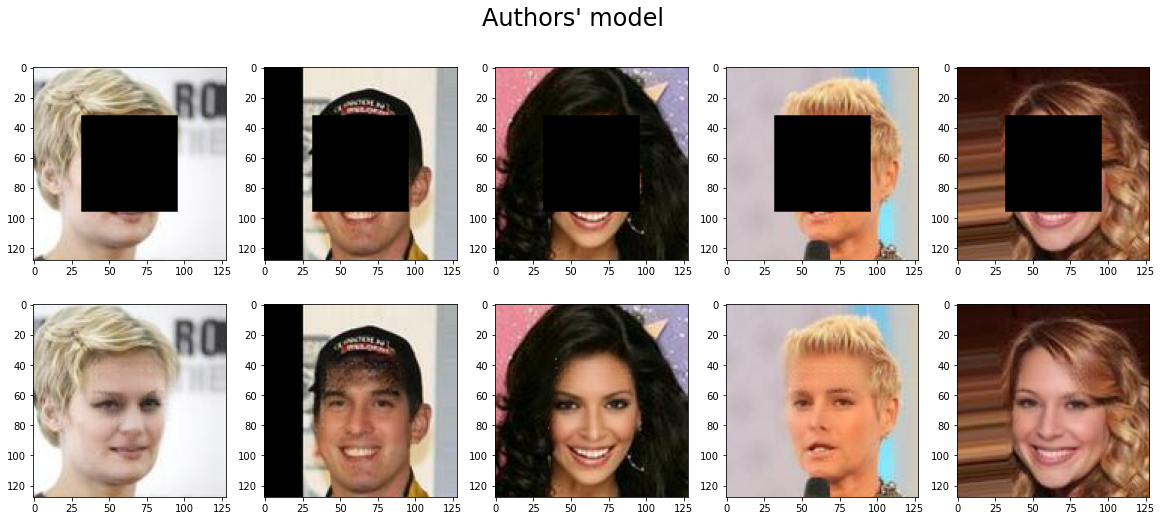

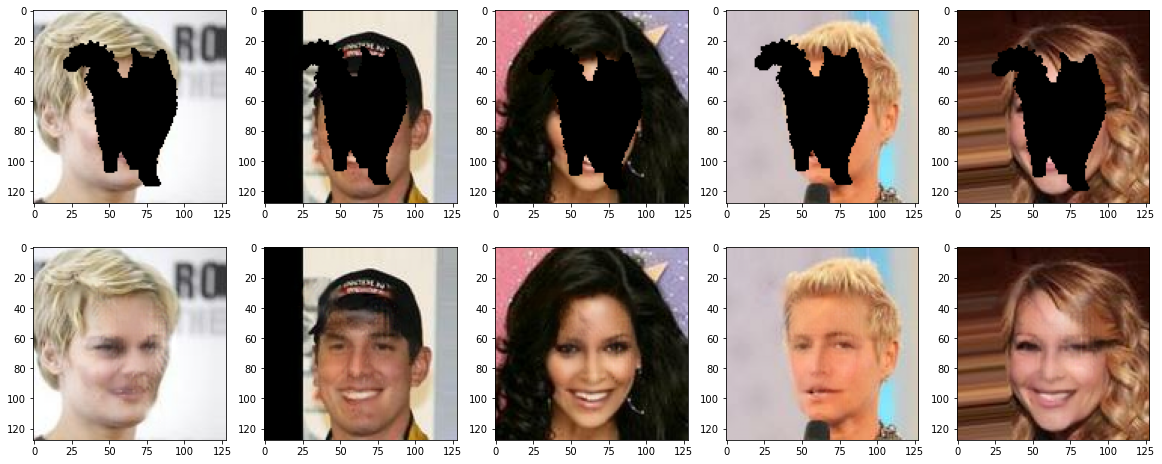

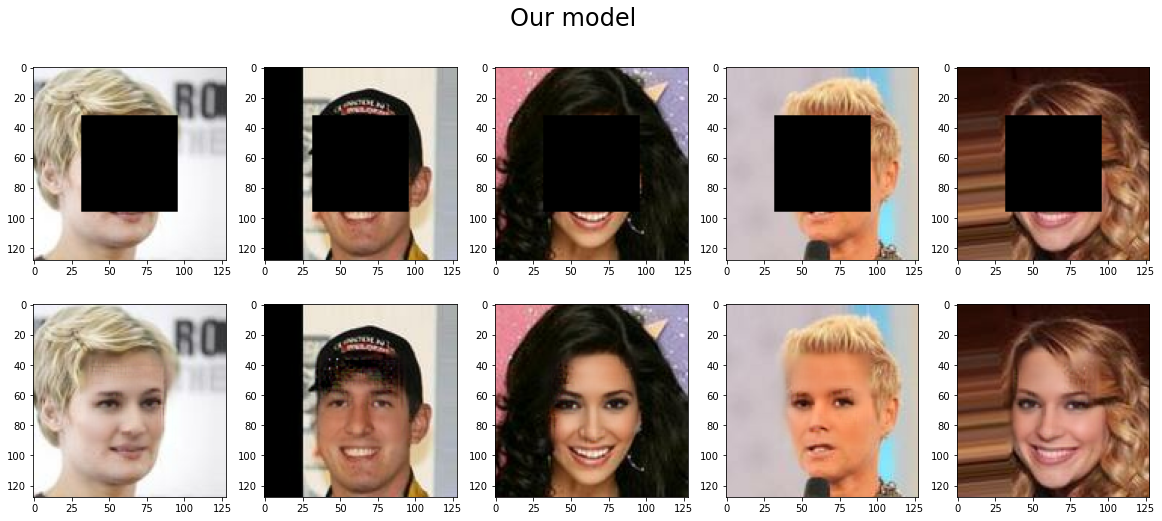

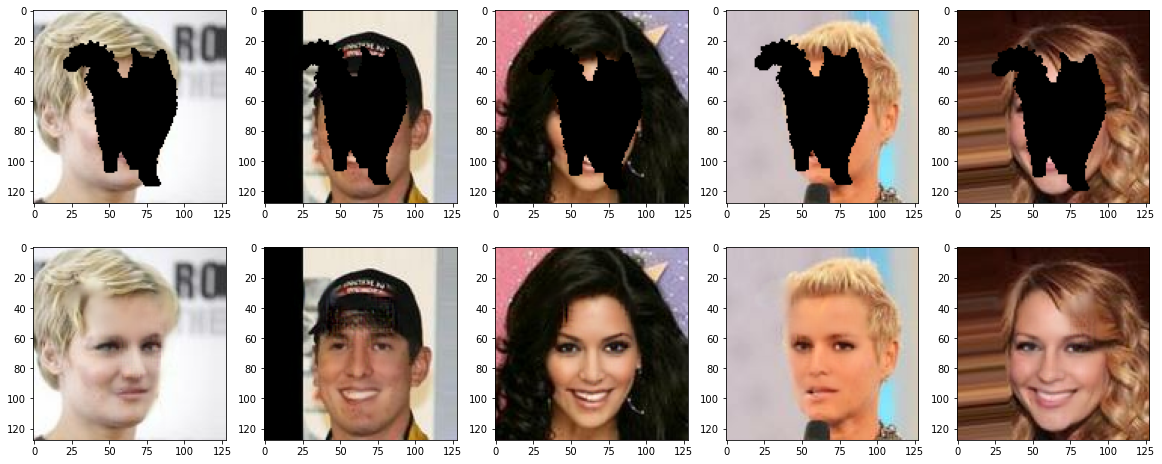

In [16]:
generator.load_weights(model_path + "gultimate_final")
critic.load_weights(model_path + "cultimate_final")
it = iter(celeba_test_customMask)
origX, newX_ss, mask_ss, randZ_ss,newX_cs, mask_cs, randZ_cs = next(it)
g_out = generator([newX_ss, mask_ss, randZ_ss])

plt.figure(figsize=(20,8))
plt.suptitle("Authors' model", fontsize=24)
for i in range(min(5, batch_size)):
    plt.subplot(2,5,i+1)
    plt.imshow(newX_ss[i,:,:,:])
    plt.subplot(2,5,i+6)
    plt.imshow(g_out[i,:,:,:])
plt.show()
g_out = generator([newX_cs, mask_cs, randZ_cs])
plt.figure(figsize=(20,8))
for i in range(min(5, batch_size)):
    plt.subplot(2,5,i+1)
    plt.imshow(newX_cs[i,:,:,:])
    plt.subplot(2,5,i+6)
    plt.imshow(g_out[i,:,:,:])
plt.show()

# Results of our model
generator.load_weights(model_path + "gultimate_ckpt110")
critic.load_weights(model_path + "cultimate_ckpt110")
g_out = generator([newX_ss, mask_ss, randZ_ss])
plt.figure(figsize=(20,8))
plt.suptitle("Our model", fontsize=24)
for i in range(min(5, batch_size)):
    plt.subplot(2,5,i+1)
    plt.imshow(newX_ss[i,:,:,:])
    plt.subplot(2,5,i+6)
    plt.imshow(g_out[i,:,:,:])
plt.show()
g_out = generator([newX_cs, mask_cs, randZ_cs])
plt.figure(figsize=(20,8))
for i in range(min(5, batch_size)):
    plt.subplot(2,5,i+1)
    plt.imshow(newX_cs[i,:,:,:])
    plt.subplot(2,5,i+6)
    plt.imshow(g_out[i,:,:,:])
plt.show()

<div class="alert alert-block alert-info">
Above code cell can be run again and again to see results over new batches of images!
You will see new results each time you run the cell.
</div>

We can clearly see that our model produces better inpainting results for the irregular cat mask!

#### Quantitative Results

Though we obtained qualititatively different results, quantitatively both were very similar as shown below.

Below is the results for the authors' model

Scenarios |PSNR |SSIM
-----|-----|----- 
Center|26.275763|0.9236164170376538
Multi|27.176897|0.9299196125368111
Noise 50|34.023598|0.9768820634915523
Noise 75|30.106485|0.9472957246744516
Noise 95|24.037521|0.8372345674968299
Custom Mask|26.274101|0.9194125268797082

Below is the results for our model

Scenarios |PSNR |SSIM
-----|-----|----- 
Center|25.89424|0.9207529952043565
Multi|26.729492|0.9275570263836425
Noise 50|33.660038|0.9746961571506488
Noise 75|29.794996|0.943318296964979
Noise 95|23.813866|0.8328322187666983
Custom Mask|26.870546|0.9286245076009202

Perhaps a better metric could be used for evaluating GANS, like the FID score.

## Conclusions and Future work

The authors aimed to present an image inpainting model based on Wasserstein Generative Adversarial Imputation Network
where the generator network uses convolutional building blocks and skip connections.
Their claim is that their implementation strategy, model architecture and dataset preparation yielded them a universal imputation model. Authors contend that universal imputation model able to handle various scenarios of missingness with sufficient quality.

They tested on three scenarios given by missing pixels at random, missing various smaller square regions, and one missing
square placed in the center of the image. The model was trained simultaneously for all of the scenarios.
However, when we tested it on our own custom irregular mask, the inpainting results were not as great as the authors affirmed it would be. Some artifacts were created in the image.
We then created our own irregular mask for training and then checked the inpainting results. It turned out to be qualitatively much better than the authors model.

Be that as it may, when comparing both of them quantitatively with PSNR and SSIM metrics, both yielded very similar results. This warrants the discussion on whether the authors used the right metrics to evaluate the WGAN.
Hence, for future work, we can try out some other metric. FID score is a very popular and more accurate metric to assess and evaluate GANs. Another popular type of GAN is the cGAN, which deals with image-image translation. This could also be tried out for future work as the end result would be the same.

## Bibliography

[FVBJ20] Magda Friedjungová, Daniel Vašata, Maksym Balatsko, and Marcel Jiˇrina. Missing features reconstruction using a wasserstein generative adversarial imputation network. In International Conference on Computational Science, pages 225–239. Springer, 2020.

[JKDW+20] Jireh Jam, Connah Kendrick, Vincent Drouard, Kevin Walker, Gee-Sern Hsu, and Moi Hoon Yap. Symmetric skip connection wasserstein gan for high-resolution facial image inpainting. arXiv preprint arXiv:2001.03725, 2020.

Vašata, D (2021) wgain-inpaint[Source Code] https://github.com/vasatdan/wgain-inpaint